In [1]:
#Imported libraries :
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import math
plt.style.use('seaborn-whitegrid')

In [3]:
data=yf.download(tickers='USD',start='2011-12-31',end='2020-12-31',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-12-30,5.721667,5.780000,5.650000,5.650000,5.339035,343200
2012-01-03,5.850000,5.945000,5.733333,5.775000,5.457153,452400
2012-01-04,5.735000,5.858333,5.693333,5.848333,5.526451,96600
2012-01-05,5.835000,6.035000,5.826667,6.028333,5.696543,267600
2012-01-06,5.933333,6.045000,5.916667,6.018333,5.687096,147000


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,100.669998,100.930000,98.790001,98.790001,98.790001,34700
2020-12-24,99.220001,100.320000,98.989998,99.870003,99.870003,29500
2020-12-28,102.059998,102.169998,99.400002,99.589996,99.589996,28500
2020-12-29,100.279999,100.300003,97.150002,99.489998,99.489998,51400
2020-12-30,100.129997,103.000000,100.129997,102.459999,102.459999,34200


In [6]:
data.shape

(2265, 6)

In [7]:
data_close = data.filter(['Close'])
forex_df = data_close.reset_index('Date')

In [8]:
forex_df.head()

,Date,Close
0,2011-12-30,5.650000
1,2012-01-03,5.775000
2,2012-01-04,5.848333
3,2012-01-05,6.028333
4,2012-01-06,6.018333


In [9]:
forex_df.tail()

,Date,Close
2260,2020-12-23,98.790001
2261,2020-12-24,99.870003
2262,2020-12-28,99.589996
2263,2020-12-29,99.489998
2264,2020-12-30,102.459999


In [12]:
#Train Data:

train_JA = forex_df[(forex_df['Date'] >= '2011-12-30') & (forex_df['Date'] <= '2019-12-31')]

In [13]:
#Test Data:

test_JA = forex_df[(forex_df['Date'] >= '2020-01-01') & (forex_df['Date'] <= '2020-12-30')]

In [14]:
print(train_JA.shape)
print(test_JA.shape)

(2013, 2)
(252, 2)


In [15]:
#selecting the target variables:
train_df = train_JA.iloc[:, 1:2].values

#selecting testing data variables:
test_df = test_JA.iloc[:, 1:2].values

In [16]:
print(train_df.shape)
print(test_df.shape)

(2013, 1)
(252, 1)


In [17]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_df = train_df.reshape(-1,1)
test_df = test_df.reshape(-1,1)

scaler.fit(train_df)
train_df = scaler.transform(train_df)

scaler.fit(test_df)
test_df = scaler.transform(test_df)

In [18]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
# Create the data to train our model on:
time_steps = 90
X_train, y_train = create_dataset(train_df, time_steps)
X_test, y_test = create_dataset(test_df, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 90, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 90, 1))

print(X_train.shape)
print(X_test.shape)

(1923, 90, 1)
(162, 90, 1)


In [20]:
#LSTM Model:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [21]:
# Build the model 
model = Sequential()

model.add(LSTM(units = 100,return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))


model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

In [22]:
# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Train on 1346 samples, validate on 577 samples
Epoch 1/20
1346/1346 [==============================] - 155s 115ms/step - loss: 0.0018 - accuracy: 7.4294e-04 - val_loss: 0.0055 - val_accuracy: 0.0017
Epoch 2/20
1346/1346 [==============================] - 153s 113ms/step - loss: 5.8199e-04 - accuracy: 7.4294e-04 - val_loss: 0.0246 - val_accuracy: 0.0017
Epoch 3/20
1346/1346 [==============================] - 151s 112ms/step - loss: 6.3783e-04 - accuracy: 7.4294e-04 - val_loss: 0.0225 - val_accuracy: 0.0017
Epoch 4/20
1346/1346 [==============================] - 155s 115ms/step - loss: 4.7343e-04 - accuracy: 7.4294e-04 - val_loss: 0.0041 - val_accuracy: 0.0017
Epoch 5/20
1346/1346 [==============================] - 147s 109ms/step - loss: 5.7662e-04 - accuracy: 7.4294e-04 - val_loss: 0.0179 - val_accuracy: 0.0017
Epoch 6/20
1346/1346 [==============================] - 149s 110ms/step - loss: 5.2209e-04 - accuracy: 7.4294e-04 - val_loss: 0.0034 - val_accuracy: 0.0017
Epoch 7/20
1346/1346 

In [23]:
# Prediction:

#styling to the Graphs: GGPlot..!!
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 6)

In [24]:
# save the model to disk
import pickle
filename = 'Forex_Predict_TS20.sav'
pickle.dump(model, open(filename, 'wb'))

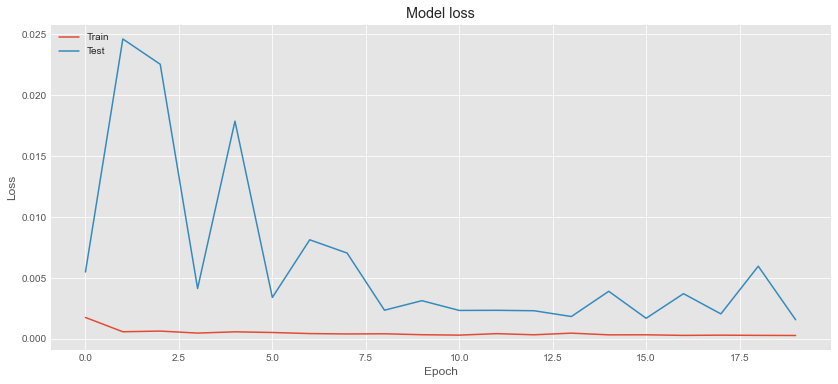

In [25]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
# Predict the prices with the model
predicted_test = model.predict(X_test)
predict_train = model.predict(X_train)

In [27]:
import math
trainScore = math.sqrt(mean_squared_error(y_train, predict_train[:,0]))
print('Train RMSE: %.2f' % (trainScore))

testScore = math.sqrt(mean_squared_error(y_test, predicted_test[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 0.02
Test RMSE: 0.05


In [28]:
predicted_y = scaler.inverse_transform(predicted_test)

In [29]:
# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

In [30]:
predicted_y.shape

(162, 1)

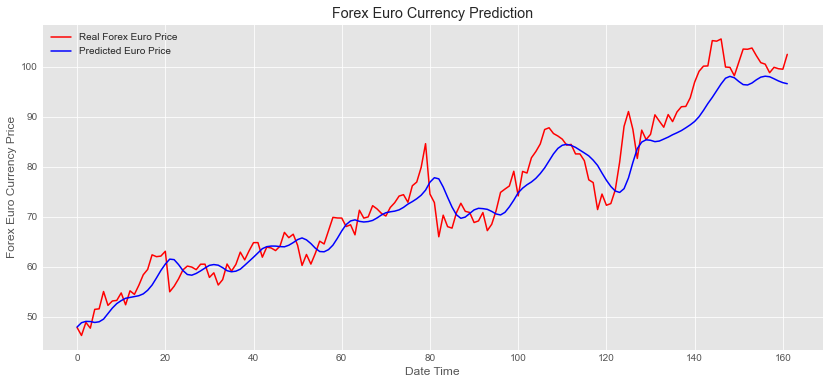

In [31]:
# plot the results
plt.plot(org_y, color = 'red', label = 'Real Forex Euro Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Euro Price')
plt.title('Forex Euro Currency Prediction')
plt.xlabel('Date Time')
plt.ylabel('Forex Euro Currency Price')
plt.legend()
plt.show()

In [32]:
# For Test Data Dates:

test_date = test_JA.iloc[:, :1].values
time_steps = 90
X_testd, y_testd = create_dataset(test_date, time_steps)
df_date = pd.DataFrame(y_testd, columns=['Date'])

In [33]:
# Making a DataFrame For Predictions Data:
df_predict = pd.DataFrame(predicted_y, columns=['Predictions'])

In [34]:
# Actual Values Data(Test Data):
test_data = test_JA.iloc[:, 1:2].values
time_steps = 90
X_test, y_test = create_dataset(test_data, time_steps)
df_av = pd.DataFrame(y_test, columns=['ActualValues'])

In [35]:
#Combining Actual Values and Predicted Values:
finaldf = pd.concat([df_date, df_av, df_predict], axis = 1)

In [36]:
finaldf.shape

(162, 3)

In [37]:
finaldf.head()

,Date,ActualValues,Predictions
0,2020-05-12,47.830002,47.930027
1,2020-05-13,46.240002,48.793442
2,2020-05-14,48.849998,49.057087
3,2020-05-15,47.700001,49.029503
4,2020-05-18,51.459999,48.841743


In [41]:
finaldf['average_value'] = finaldf[['ActualValues', 'Predictions']].mean(axis=1)

In [42]:
finaldf.head()

,Date,ActualValues,Predictions,average_value
0,2020-05-12,47.830002,47.930027,47.880014
1,2020-05-13,46.240002,48.793442,47.516722
2,2020-05-14,48.849998,49.057087,48.953543
3,2020-05-15,47.700001,49.029503,48.364752
4,2020-05-18,51.459999,48.841743,50.150871


In [43]:
# getting Difference
finaldf['value_diff'] = finaldf['ActualValues'] - finaldf['Predictions']

In [44]:
finaldf.head()

,Date,ActualValues,Predictions,average_value,value_diff
0,2020-05-12,47.830002,47.930027,47.880014,-0.100025
1,2020-05-13,46.240002,48.793442,47.516722,-2.553440
2,2020-05-14,48.849998,49.057087,48.953543,-0.207088
3,2020-05-15,47.700001,49.029503,48.364752,-1.329502
4,2020-05-18,51.459999,48.841743,50.150871,2.618256
